In [1]:
import pandas as pd
import numpy as np
from ggplot import *
% matplotlib inline

# Define Mortgage Details: 

In [2]:
def calculate_montly_payment(n,L,monthly_interest):
    I = monthly_interest
    numerator = L*(1 + I)**n
    denomenator = -1*(1 - (1 + I)**n) / I
    return (numerator/denomenator)

In [25]:
# Enter Best Estimates Here
time = 30 # number of years
interest = .039 #percent/100
price = 319000 # dollars
down_payment = .2 # percent/100
marginal_tax_rate = .25
property_tax = .01
yearly_house_appreciation = .01
hoa_fee = 100
homeowner_insurance = 67
monthly_rent = 1850
rent_percent = .5 #percent of monthly rent as income

In [26]:
# For calculations: do not edit
n = time * 12 #number of months for the loan
L = price * (1.0 - down_payment) # loan amount
monthly_interest = interest/12.0 # monthly interest rate as a percent/100
p = calculate_montly_payment(n,L,monthly_interest) # monthly payment
print 'Monthly Payment = %d'%p

Monthly Payment = 1203


# Calculate Cumulative Equity and Interest per month: 

In [5]:
mortgage = pd.DataFrame()
loan = L
month_list = range(1,n+1)
for month in month_list:
    mortgage_month = pd.DataFrame()
    mortgage_month['Month'] = [month]
    mortgage_month['Loan_Before_Payment'] = np.round(loan)
    loan = loan * (1+ monthly_interest) - p
    mortgage_month['Loan_After_Payment'] = np.round(loan)
    mortgage_month['Equity_Gain'] = mortgage_month['Loan_Before_Payment'] - mortgage_month['Loan_After_Payment']
    mortgage = pd.concat([mortgage,mortgage_month])
mortgage['Interest_Paid'] = np.round(p - mortgage['Equity_Gain'])
mortgage['Tax_Savings'] = np.round(mortgage['Interest_Paid'] * marginal_tax_rate)
mortgage['Effective_Interest_Paid'] = np.round(mortgage['Interest_Paid'] * (1-marginal_tax_rate))
mortgage['Cumulative_Equity_Gain'] = mortgage['Equity_Gain'].cumsum()
mortgage['Cumulative_Interest_Paid'] = mortgage['Interest_Paid'].cumsum()
mortgage['Cumulative_Effective_Interest_Paid'] = mortgage['Effective_Interest_Paid'].cumsum()
mortgage['Year'] = np.ceil(mortgage['Month']/12.0)
mortgage['Total_Equity_With_Appreciation'] = np.round(mortgage['Cumulative_Equity_Gain'] * (1 + yearly_house_appreciation)**mortgage['Year'])
mortgage.set_index([range(len(mortgage))], inplace = True)
mortgage

,Month,Loan_Before_Payment,Loan_After_Payment,Equity_Gain,Interest_Paid,Tax_Savings,Effective_Interest_Paid,Cumulative_Equity_Gain,Cumulative_Interest_Paid,Cumulative_Effective_Interest_Paid,Year,Total_Equity_With_Appreciation
0,1,255200,254826,374,830,208,622,374,830,622,1,378
1,2,254826,254450,376,828,207,621,750,1658,1243,1,758
2,3,254450,254073,377,827,207,620,1127,2485,1863,1,1138
3,4,254073,253695,378,826,206,620,1505,3311,2483,1,1520
4,5,253695,253316,379,825,206,619,1884,4136,3102,1,1903
5,6,253316,252936,380,824,206,618,2264,4960,3720,1,2287
6,7,252936,252554,382,822,206,616,2646,5782,4336,1,2672
7,8,252554,252171,383,821,205,616,3029,6603,4952,1,3059
8,9,252171,251787,384,820,205,615,3413,7423,5567,1,3447
9,10,251787,251402,385,819,205,614,3798,8242,6181,1,3836


In [6]:
plot_data = pd.melt(mortgage[['Month','Cumulative_Equity_Gain','Cumulative_Effective_Interest_Paid','Cumulative_Interest_Paid']], id_vars = ['Month'], value_vars = ['Cumulative_Equity_Gain','Cumulative_Effective_Interest_Paid','Cumulative_Interest_Paid'])

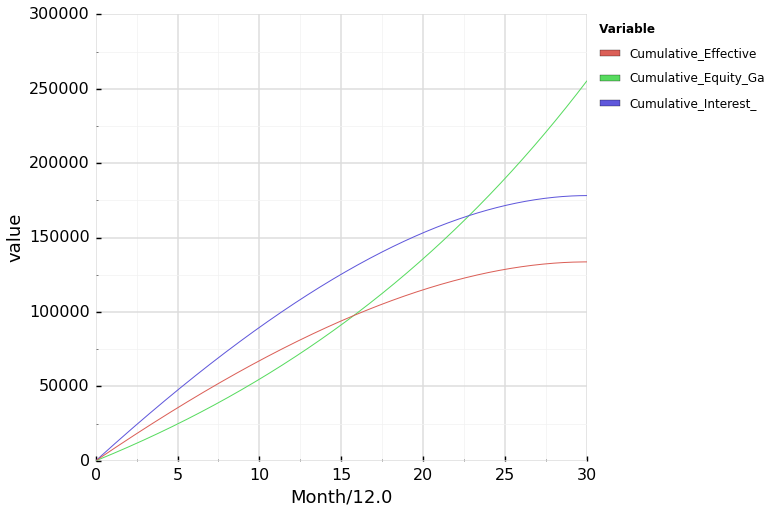

<ggplot: (24448288)>

In [7]:
ggplot(aes(x = 'Month/12.0', y = 'value', color = 'variable'), data = plot_data)\
+ geom_line()\
+ theme_seaborn(context = 'poster')
 

In [8]:
plot_data_monthly = pd.melt(mortgage[['Month','Equity_Gain','Effective_Interest_Paid','Interest_Paid']], id_vars = ['Month'], value_vars = ['Equity_Gain','Effective_Interest_Paid','Interest_Paid'])

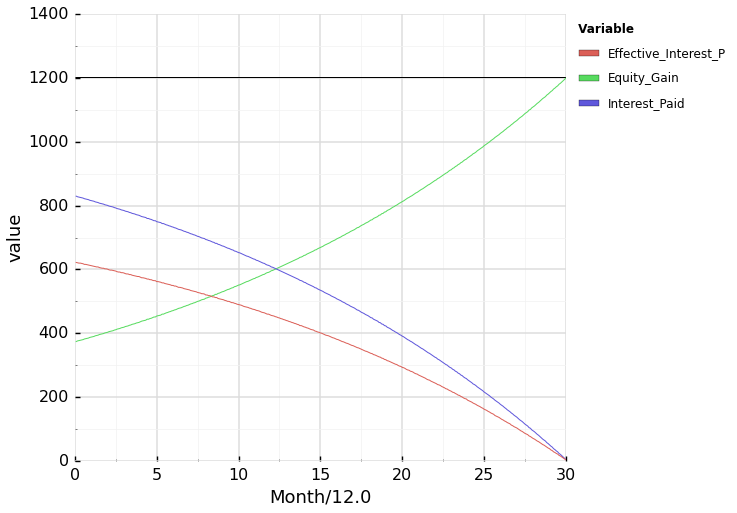

<ggplot: (29122066)>

In [9]:
ggplot(aes(x = 'Month/12.0', y = 'value', color = 'variable'), data = plot_data_monthly)\
+ geom_line()\
+ geom_hline(yintercept = [np.round(p)], color = 'black')\
+ theme_seaborn(context = 'poster')
 

# Yearly Info

In [17]:
yearly_mortgage = mortgage[mortgage.Month%12 == 0]
yearly_mortgage = yearly_mortgage[['Year','Cumulative_Effective_Interest_Paid','Total_Equity_With_Appreciation']]
yearly_mortgage['Total_Equity_With_Appreciation'] = np.round(yearly_mortgage['Total_Equity_With_Appreciation'] + (down_payment * price) * (1 + yearly_house_appreciation)**yearly_mortgage['Year'])
yearly_mortgage['House_Value'] = np.round(price * (1 + yearly_house_appreciation)**yearly_mortgage['Year'])
yearly_mortgage['Effective_Property_Tax'] = np.round(property_tax * yearly_mortgage['House_Value'] * (1 - marginal_tax_rate))
yearly_mortgage['Cumulative_Effective_Property_Tax'] = yearly_mortgage['Effective_Property_Tax'].cumsum()
yearly_mortgage['HOA'] = 12 * hoa_fee
yearly_mortgage['Cumulative_HOA'] = yearly_mortgage['HOA'].cumsum()
yearly_mortgage['Homeowner_Insurance'] = 12 *homeowner_insurance
yearly_mortgage['Cumulative_Homeowner_Insurance'] = yearly_mortgage['Homeowner_Insurance'].cumsum()
yearly_mortgage['Total_Cost'] = yearly_mortgage['Cumulative_Effective_Property_Tax'] + yearly_mortgage['Cumulative_Effective_Interest_Paid'] + yearly_mortgage['Cumulative_HOA'] + yearly_mortgage['Cumulative_Homeowner_Insurance']
yearly_mortgage['Rent_Income'] = 12 * monthly_rent * rent_percent
yearly_mortgage['Total_Rent_Income'] = yearly_mortgage['Rent_Income'].cumsum()
yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Total_Rent_Income']
yearly_mortgage['Net_Gain'] = yearly_mortgage['Total_Equity_With_Appreciation'] - yearly_mortgage['Effective_Cost']
yearly_mortgage.head(30)

,Year,Cumulative_Effective_Interest_Paid,Total_Equity_With_Appreciation,House_Value,Effective_Property_Tax,Cumulative_Effective_Property_Tax,HOA,Cumulative_HOA,Homeowner_Insurance,Cumulative_Homeowner_Insurance,Total_Cost,Rent_Income,Total_Rent_Income,Effective_Cost,Net_Gain
11,1,7406,69057,322190,2416,2416,1200,1200,804,804,11826,11100,11100,726,68331
23,2,14676,74596,325412,2441,4857,1200,2400,804,1608,23541,11100,22200,1341,73255
35,3,21805,80435,328666,2465,7322,1200,3600,804,2412,35139,11100,33300,1839,78596
47,4,28786,86588,331953,2490,9812,1200,4800,804,3216,46614,11100,44400,2214,84374
59,5,35613,93070,335272,2515,12327,1200,6000,804,4020,57960,11100,55500,2460,90610
71,6,42282,99898,338625,2540,14867,1200,7200,804,4824,69173,11100,66600,2573,97325
83,7,48787,107089,342011,2565,17432,1200,8400,804,5628,80247,11100,77700,2547,104542
95,8,55119,114663,345431,2591,20023,1200,9600,804,6432,91174,11100,88800,2374,112289
107,9,61273,122639,348886,2617,22640,1200,10800,804,7236,101949,11100,99900,2049,120590
119,10,67241,131037,352374,2643,25283,1200,12000,804,8040,112564,11100,111000,1564,129473


In [18]:
total_plot = pd.melt(yearly_mortgage[['Year','Total_Equity_With_Appreciation','Total_Cost','Total_Rent_Income','Effective_Cost','Net_Gain']], id_vars = ['Year'], value_vars = ['Total_Equity_With_Appreciation','Total_Cost','Total_Rent_Income','Effective_Cost','Net_Gain'])

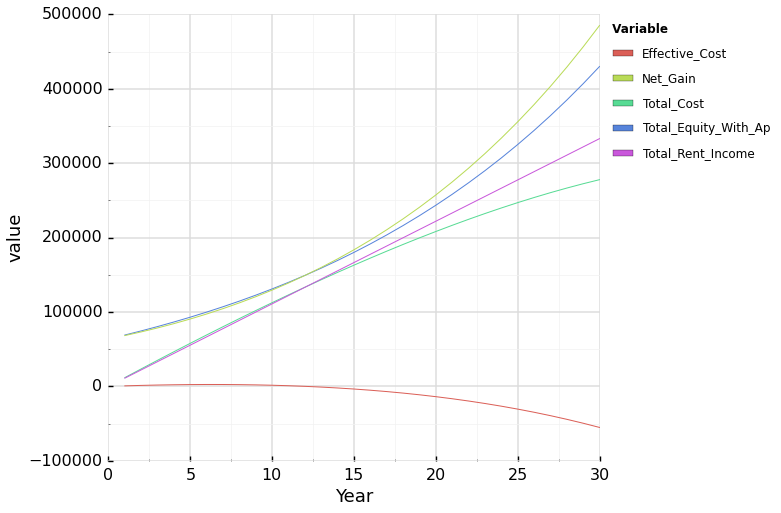

<ggplot: (29101768)>

In [19]:
ggplot(aes(x = 'Year', y = 'value', color = 'variable'), data = total_plot)\
+ geom_line()\
+ theme_seaborn(context = 'poster')
 